# Bayesian brain model of an attentional phenomenon
Benjamin T. Vincent, [@inferenceLab](https://twitter.com/inferencelab)

_This notebook uses an 'easier' approach than that used in Vincent (2015a). We just construct a forward model of the task, then get the computer to do the simulation and inference to end up at (hopefully) the same result._

This notebook moves on from the linear regression example where the model _describes_ the data, and from the discounting model which potentially _explains_ the data, to look at another explanatory model. This kind of model is often referred to as a 'Bayesian brain' model in that our model is that participants themselves are conducting Bayesian inference about the state of the world. Another way of saying this is that we are graduating from us as scientists being Bayesian, to considering whether people are Bayesian. 

We will not fully explore this here, but we will replicate the Bayesian optimal observer predictions made in Vincent (2011), and later discussed in a broader review of Bayesian explanations of attentional phenomena (Vincent, 2015a). 

## The task
This is a covert attentional task where participants look at a computer screen:
- They fixate the centre of the screen so that stimuli which later appear are all equidistant from the fovea. 
- A cue appears uniformly randomly in one of $N$ locations before disappearing. 
- The participants have been informed about the validity of the cue in advance. For example, if the cue is 80% valid, then there is an 80% chance that a target object will appear at the cued location and a 20% of being in one of the other $N-1$ locations. 
- Distractors appear in all other locations. 
- The stimulus items are chosen to be visually similar and to appear for short durations of time, so that there is remaining uncertainty about the target's location.

<img src="img/cued localisation.png" width="600">

## The theoretical question asked in Vincent (2011)
The main aim was to see if participants acted in a Bayesian manner by incorporating prior information (from the cue) and the likelihood (sensory information consistent with hypotheses about the world). 

Vincent (2011) examined how people's performance in a cued localisation task varied depending on how valid the cue was. People's performance was worst when the cue was uninformative - in this case with 4 locations this was when the cue was valid 1/4 of the time. Performance improved when the cue was more predictive of the target location, suggesting that participants did combine their prior beliefs (from the cue) with the likelihood (from the stimuli). However, it was also the case that performance improved when the cue signalled where a target would be _less_ likely to appear. For example, when it was 0% valid the target was never at the cued location. Participants were able to use the information from the cue so as to update their beliefs that the targets were more likely to occur in the remaining locations, which lead to enhanced performance.

<img src="img/vincent2011.png" width="400">

There were some interesting peculiarities about the participant's performance which indicated that while they combined the cue-derived prior beliefs and the stimulus-based likelihood, they seemed to have biases in their beliefs akin to those seen in Prospect Theory. In this notebook, we will ignore this fascinating probability bias issue and focus on replicating the optimal observer predictions as shown in Figure 3 of Vincent (2011) and expanded upon in Figure 8 of Vincent (2015a). Further information about Bayesian optimal observer models of covert visual attention can be found in Vincent (2015a). Further useful background into Bayesian modelling of perception can be found in Vincent (2015b).

**Note:** The original Matlab code associated with Vincent (2011) is in GitHub at [drbenvincent/BayesCovertAttention](https://github.com/drbenvincent/BayesCovertAttention). Although beware, I was a less seasoned programmer at that point, so apologies if the code is not as clear as it could be.

## Let's start coding

In [1]:
using Turing, StatsPlots

This function is where the magic happens. We are going to construct a generative model of the task covering:
- cue location
- how that influences the probability of where the target appears
- how the target (and distractor) locations influence noisy sensory observations

In [2]:
@model function generative_model(N, v, σ, C, T, x)
    
    # cue equally likely to appear in 1 of N locations
    C ~ DiscreteUniform(1, N)
    
    # prior of target location: v at the cued location, (1-v)/(N-1) at all other locations
    prior = fill((1-v)/(N-1), N)
    prior[C] = v
    
    # target location
    T ~ Categorical(prior)
    
    # noisy sensory observations
    if x === missing
        # Initialize `x` if missing
        x = Vector(undef, N)
    end
    for i in 1:N
        # μ=1 at target location 1, μ=0 at other locations
        x[i] ~ Normal(i==T ? 1.0 : 0.0, σ)
    end
    
    return C, T, x
end;

We are going to see how we can use this generative model in 2 ways. We can use the same model to:
1. **Simulate** cue and target locations as well as noisy sensory observations experienced by the Bayesian optimal observer.
2. **Infer** the location of the cue, given knowledge of the sensory observations, cue validity, cue location, _but not the target location_.

We can simulate as follows:

```julia
simulate_model = generative_model(N, v, σ, missing, missing, missing)
C, T, x = simulate_model()
```

and we can do inference with:

```julia
infer_model = generative_model(N, v, σ, C, missing, x)
posterior_chain = sample(infer_model, MH(), posterior_samples)
```

This is actually quite cool.

Now all we need to do is to write some code to simulate a trial...

In [3]:
function simulate_trial(N, v, σ; posterior_samples = 500)
    
    # 1: Generate simulated data
    prior_sample = generative_model(N, v, σ, missing, missing, missing)  # use model
    C, T, x = prior_sample()
    
    # 2: Inferences about target location
    model = generative_model(N, v, σ, C, missing, x)
    posterior_chain = sample(model, MH(), posterior_samples)
    t_dist = Array(posterior_chain["T"])
    posterior = [sum(t_dist.==i) / posterior_samples for i in 1:N]
    
    # 3: Response of Bayesian optimal observer 
    response = argmax(posterior)
    correct = response == T ? 1 : 0
    
    return correct
end;

We will need to repeat this many times to average over what sensory information we happen to get on one particular trial.

In [4]:
"""Estimate proportion correct by repeating simulated trials with the same
parameters many times. We are marginalising over the noisy sensory inputs"""
function repeat_trials(N, v, σ, simulated_trials)
    sum([simulate_trial(N, v, σ) 
            for i in 1:simulated_trials])/ simulated_trials
end;

In [5]:
function simulate_experiment(N, σ, cue_validities, simulated_trials)
    proportion_correct = zeros(length(cue_validities))
    for (iv, v) in enumerate(cue_validities)
        proportion_correct[iv] = repeat_trials(N, v, σ, simulated_trials)
    end
    return proportion_correct
end;

**Note:** this simulation code can take some minutes to compute.

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 

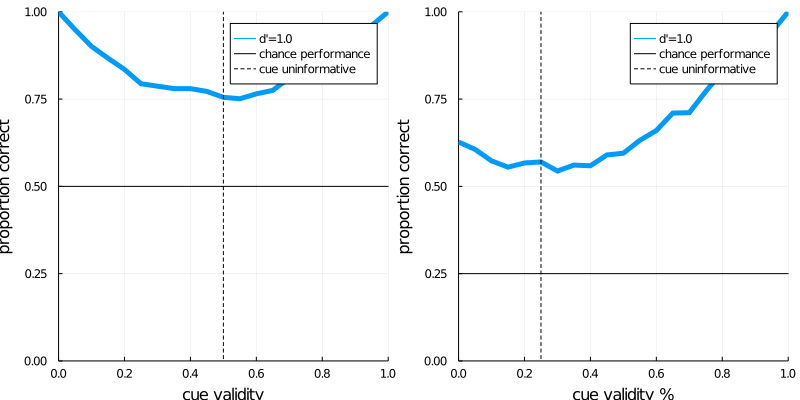

In [6]:
σ = 1
simulated_trials = 1000
cue_validities = LinRange(0.0, 1.0, 21)

plot(layout=(1, 2), size=(800, 400))

# set size N=2 ===========================================================
N, subplot = 2, 1
proportion_correct = simulate_experiment(N, σ, cue_validities, simulated_trials)

plot!(cue_validities, proportion_correct, lw=5, label="d'=$(1/σ)", subplot=subplot)
plot!(xlim=(0, 1), ylim=(0, 1), 
    xlabel="cue validity", ylabel="proportion correct", subplot=subplot)
hline!([1/N], color=:black, label="chance performance", subplot=subplot)
vline!([1/N], color=:black, label="cue uninformative", linestyle=:dash, subplot=subplot)
plot!(yticks=[0:0.25:1;])

# set size N=4 ===========================================================
N, subplot = 4, 2
proportion_correct = simulate_experiment(N, σ, cue_validities, simulated_trials)

plot!(cue_validities, proportion_correct, lw=5, label="d'=$(1/σ)", subplot=subplot)
plot!(xlim=(0, 1), ylim=(0, 1), 
    xlabel="cue validity %", ylabel="proportion correct", subplot=subplot)
hline!([1/N], color=:black, label="chance performance", subplot=subplot)
vline!([1/N], color=:black, label="cue uninformative", linestyle=:dash, subplot=subplot)
plot!(yticks=[0:0.25:1;])

It worked! We now have pretty concise code to replicate the Bayesian optimal observer predictions in Vincent (2011), and more specifically, Figure 8 in Vincent (2015a).

<img src="img/vincent_2015_figure_8.png" width="800">

## Going further: Estimating the $d'$ parameter based on behavioural data
While this is very useful, the next step would be to build on this and to estimate the $d'$ of an observer based upon behavioural data. I will leave this as an exercise for the reader, but the general approach might be:
- think about the behavioural data we would have and whether the analysis runs at the trial level or the participant level
- think about an appropriate likelihood, which depends upon whether we are modelling trial level correct/incorrect responses, or participant level number or proportion correct data
- use (or adapt) the existing `simulated_response()` function and embed it within a Bayesian model using Turing.jl
- construct appropriate priors
- sample from the posterior to estimate something like $P(d' | N, \text{response data}, \text{cue validities})$

# References
- Vincent, B. (2011). Covert visual search: Prior beliefs are optimally combined with sensory evidence. Journal of Vision, 11(13), 25-25.
- Vincent, B. T. (2015a). Bayesian accounts of covert selective attention: a tutorial review. Attention, Perception, & Psychophysics, 77(4), 1013-1032.
- Vincent, B. T. (2015b). A tutorial on Bayesian models of perception. Journal of Mathematical Psychology, 66, 103-114.